In [ ]:
# teste realizado com sucesso, agora treinar com o proprio dataset
#criar pasta workspace/training_demo dentro da pasta tensorflow

%cd TensorFlow

!mkdir -p workspace/training_demo/annotations 
!mkdir -p workspace/training_demo/exported-models 
!mkdir -p workspace/training_demo/images/test
!mkdir -p workspace/training_demo/images/train 
!mkdir -p workspace/training_demo/models
!mkdir -p workspace/training_demo/pre-trained-models
#criar pasta scripts/preprocessing
#!mkdir -p scripts/preprocessing

In [1]:
%cd TensorFlow

/home/smart/Desktop/Bruno/TensorFlow


In [ ]:
#aq eh o script de divisao em treino e teste
#para nao ficar com muito codigo aqui neste notebook
#copiei e puis ele direto em scripts/preprocessing/partition_dataset.py

In [2]:
#considerando minha pasta com todas as imagens esta aq no msm diretorio do notebook
import glob

#contar quantidade de total de imagens na pasta do drive
qtd_imgs = len(glob.glob("/home/smart/Desktop/Bruno/frames_marcados_04-09_a_13-09/*.jpg"))
print("Quantidade de imagens:", qtd_imgs)

#executando script de divisao, mudar pra caminho da pasta de origem e destino
#!python scripts/preprocessing/partition_dataset.py -x -i /home/smart/Desktop/Bruno/frames_marcados -o workspace/training_demo/images -r 0.1

#contar quantidade de total de imagens na pasta treino e teste
qtd_imgs_train = len(glob.glob("workspace/training_demo/images/train/*.xml"))
print("Quantidade de imagens de treino:", qtd_imgs_train)
qtd_imgs_test = len(glob.glob("workspace/training_demo/images/test/*.xml"))
print("Quantidade de imagens de teste:", qtd_imgs_test)

Quantidade de imagens: 0
Quantidade de imagens de treino: 192
Quantidade de imagens de teste: 56


In [ ]:
#aplicacao do aumento de dados
from data_aug.data_aug import *
from data_aug.bbox_util import *
import numpy as np
from shutil import copy #copiar imagens para teste
import glob
import xml.etree.ElementTree as ET #manipular xml
import cv2 
#!pip install imageio
import imageio #salvar imagem
#!pip install pascal-voc-writer
from pascal_voc_writer import Writer #escrever formato pascal voc

In [ ]:
#funcao para ler xml / adicionei pegar classes
def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    classes = []
    
    for boxes in root.iter('object'):
        
        for box in boxes.findall("name"):
            classes.append(box.text)

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes, classes

In [ ]:
# HORIZONTAL TREINO
# pegar nomes dos arquivos nas pastas para o treino
treino_jpg = glob.glob("workspace/training_demo/images/train/*.JPG")
treino_xml = glob.glob("workspace/training_demo/images/train/*.xml")
treino_jpg.sort()
treino_xml.sort()

#aplicar horizontal nas imagens originais do treino
for i in range(len(treino_jpg)):
    # pegar arquivo xml e imagem atual
    name, boxes, classes = read_content(treino_xml[i])
    boxes = np.asarray(boxes)
    z = np.zeros((boxes.shape[0],1))
    anotacoes = np.append(boxes, z, axis=1)
    img = cv2.imread(treino_jpg[i])[:,:,::-1]
    
    #aplicando DA
    imgNew, anotacoesNew = RandomHorizontalFlip(1)(img.copy(), anotacoes.copy())
    #pegando novo nome
    nameNew = os.path.splitext(name)[0]
    nameNew = nameNew + '_hor' + '.jpg'
    #salvar nova imagem - especificar caminho se é TRAIN ou VALIDATION
    imageio.imwrite('workspace/training_demo/images/train/'+str(nameNew), imgNew)
    
    # Writer(path, width, height)
    writer = Writer(nameNew, imgNew.shape[1], imgNew.shape[0])
    
    # ::addObject(name, xmin, ymin, xmax, ymax)
    for k in range(anotacoesNew.shape[0]):
        writer.addObject(classes[k], int(anotacoesNew[k,0]), int(anotacoesNew[k,1]),
                         int(anotacoesNew[k,2]), int(anotacoesNew[k,3]))

    # ::save(path)
    writer.save('workspace/training_demo/images/train/'+os.path.splitext(nameNew)[0]+'.xml')    

In [ ]:
#OPCIONAL ------ SE TEST FOR GRANDE NEM PRECISA FAZER

# HORIZONTAL TEST
# pegar nomes dos arquivos nas pastas para o treino
treino_jpg = glob.glob("workspace/training_demo/images/test/*.JPG")
treino_xml = glob.glob("workspace/training_demo/images/test/*.xml")
treino_jpg.sort()
treino_xml.sort()

#aplicar horizontal nas imagens originais do treino
for i in range(len(treino_jpg)):
    # pegar arquivo xml e imagem atual
    name, boxes, classes = read_content(treino_xml[i])
    boxes = np.asarray(boxes)
    z = np.zeros((boxes.shape[0],1))
    anotacoes = np.append(boxes, z, axis=1)
    img = cv2.imread(treino_jpg[i])[:,:,::-1]
    
    #aplicando DA
    imgNew, anotacoesNew = RandomHorizontalFlip(1)(img.copy(), anotacoes.copy())
    #pegando novo nome
    nameNew = os.path.splitext(name)[0]
    nameNew = nameNew + '_hor' + '.jpg'
    #salvar nova imagem - especificar caminho se é TRAIN ou VALIDATION
    imageio.imwrite('workspace/training_demo/images/test/'+str(nameNew), imgNew)
    
    # Writer(path, width, height)
    writer = Writer(nameNew, imgNew.shape[1], imgNew.shape[0])
    
    # ::addObject(name, xmin, ymin, xmax, ymax)
    for k in range(anotacoesNew.shape[0]):
        writer.addObject(classes[k], int(anotacoesNew[k,0]), int(anotacoesNew[k,1]),
                         int(anotacoesNew[k,2]), int(anotacoesNew[k,3]))

    # ::save(path)
    writer.save('workspace/training_demo/images/test/'+os.path.splitext(nameNew)[0]+'.xml')    

In [ ]:
# CORTES TREINO
# pegar nomes dos arquivos nas pastas para o treino
treino_jpg = glob.glob("workspace/training_demo/images/train/*.jpg")
treino_xml = glob.glob("workspace/training_demo/images/train/*.xml")
treino_jpg.sort()
treino_xml.sort()

#aplicar cortes nas imagens originais e horizontais do treino
for j in range(len(treino_jpg)):
    # pegar arquivo xml e imagem atual
    name, boxes, classes = read_content(treino_xml[j])
    boxes = np.asarray(boxes)
    z = np.zeros((boxes.shape[0],1))
    anotacoes = np.append(boxes, z, axis=1)
    img = cv2.imread(treino_jpg[j])[:,:,::-1]
    
    for k in range(7): #quantidade de cortes gerados: 100 + 900*100 = 1000
    
        #aplicando DA para corte
        #arrumando anotacoes
        anotacoes = np.where(anotacoes==0, 2, anotacoes)
        anotacoes = np.where(anotacoes==1, 2, anotacoes)
        anotacoes = np.where(anotacoes==img.shape[0], img.shape[0]-1, anotacoes)
        anotacoes = np.where(anotacoes==img.shape[1], img.shape[1]-1, anotacoes)

        minX = anotacoes[:,[0,2]].min()
        minY = anotacoes[:,[1,3]].min()
        maxX = anotacoes[:,[0,2]].max()
        maxY = anotacoes[:,[1,3]].max()

        imgCortada = (random.randint(1,minX), random.randint(1,minY), 
                  random.randint(maxX+1,img.shape[1]), random.randint(maxY+1,img.shape[0]))

        imgNew = img[imgCortada[1]:imgCortada[3], imgCortada[0]:imgCortada[2]]

        anotacoesNew = np.ones((anotacoes.shape[0], 5)) #so pra pegar mesmo tamanho da original
        for i in range(anotacoesNew.shape[0]):
            anotacoesNew[i] = np.array([[anotacoes[i,0]-imgCortada[0], anotacoes[i,1]-imgCortada[1], 
                                         anotacoes[i,2]-imgCortada[0], anotacoes[i,3]-imgCortada[1], 0]])    

        #pegando novo nome
        nameNew = os.path.splitext(name)[0]
        nameNew = nameNew + '_cort_' + str(k+1) + '.jpg'
        #salvar nova imagem - especificar caminho se é TRAIN ou VALIDATION
        imageio.imwrite('workspace/training_demo/images/train/'+str(nameNew), imgNew)

        # Writer(path, width, height)
        writer = Writer(nameNew, imgNew.shape[1], imgNew.shape[0])

        # ::addObject(name, xmin, ymin, xmax, ymax)
        for i in range(anotacoesNew.shape[0]):
                writer.addObject(classes[i], int(anotacoesNew[i,0]), int(anotacoesNew[i,1]),
                                int(anotacoesNew[i,2]), int(anotacoesNew[i,3]))

        # ::save(path)
        writer.save('workspace/training_demo/images/train/'+os.path.splitext(nameNew)[0]+'.xml')    

In [ ]:
import glob 
%cd TensorFlow
caminhoXML = glob.glob('workspace/training_demo/images/train/*.xml')
caminhoJPG = glob.glob('workspace/training_demo/images/train/*.JPG')
print("Qtd train xml:", len(caminhoXML))
print("Qtd train jpg:", len(caminhoJPG))

caminhoXML = glob.glob('workspace/training_demo/images/test/*.xml')
caminhoJPG = glob.glob('workspace/training_demo/images/test/*.JPG')
print("Qtd test xml:", len(caminhoXML))
print("Qtd test jpg:", len(caminhoJPG))

In [ ]:
#%cd ..
#%cd ..

In [3]:
%%writefile workspace/training_demo/annotations/label_map.pbtxt
item {
  id: 1
  name: 'Schistosoma'
}

Writing workspace/training_demo/annotations/label_map.pbtxt


In [ ]:
%%writefile workspace/training_demo/annotations/label_map.pbtxt
item {
  id: 1
  name: 'base_disjuntor'
}
item {
  id: 2
  name: 'disjuntor_isolador'
}
item {
  id: 3
  name: 'chave_passaros'
}
item {
  id: 4
  name: 'barramento'
}
item {
  id: 5
  name: 'chave_tripolar'
}
item {
  id: 6
  name: 'disjuntor_tc_externo'
}
item {
  id: 7
  name: 'tc_externo'
}

In [ ]:
#aq eh o script de transformar anotacoes em formato TFRecords
#para nao ficar com muito codigo aqui neste notebook
#copiei e puis ele direto em scripts/preprocessing/generate_tfrecord.py

In [4]:
# criar TFRecords do treinamento
!python scripts/preprocessing/generate_tfrecord.py -x workspace/training_demo/images/train -l workspace/training_demo/annotations/label_map.pbtxt -o workspace/training_demo/annotations/train.record

# criar TFRecords do teste
!python scripts/preprocessing/generate_tfrecord.py -x workspace/training_demo/images/test -l workspace/training_demo/annotations/label_map.pbtxt -o workspace/training_demo/annotations/test.record

Successfully created the TFRecord file: workspace/training_demo/annotations/train.record
Successfully created the TFRecord file: workspace/training_demo/annotations/test.record


In [ ]:
#%cd TensorFlow
!pwd

In [ ]:
#baixando modelo pre-treinado e depois decompactando
#!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
#!tar -xvf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz -C workspace/training_demo/pre-trained-models/

#!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz
#!tar -xvf ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz -C workspace/training_demo/pre-trained-models/

#!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_800x1333_coco17_gpu-8.tar.gz
#!tar -xvf faster_rcnn_resnet50_v1_800x1333_coco17_gpu-8.tar.gz -C workspace/training_demo/pre-trained-models/

#!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
#!tar -xvf faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz -C workspace/training_demo/pre-trained-models/

#!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8.tar.gz
#!tar -xvf faster_rcnn_resnet152_v1_800x1333_coco17_gpu-8.tar.gz -C workspace/training_demo/pre-trained-models/

#!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_inception_resnet_v2_1024x1024_coco17_tpu-8.tar.gz
#!tar -xvf faster_rcnn_inception_resnet_v2_1024x1024_coco17_tpu-8.tar.gz -C workspace/training_demo/pre-trained-models/

#!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8.tar.gz
#!tar -xvf faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8.tar.gz -C workspace/training_demo/pre-trained-models/

#para outros modelos fazer mesma coisa, so mudar o link e nome na descompactacao

In [5]:
#nome do modelo que irei trabalhar
name_model_original = 'faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8'
name_model = 'dataset2_210122_schisto_faster_rcnn_resnet152_1024x1024'

#criar pasta no models e copiar pipeline.config para minha pasta particular
!mkdir -p workspace/training_demo/models/$name_model/
!cp workspace/training_demo/pre-trained-models/$name_model_original/pipeline.config workspace/training_demo/models/$name_model

#depois disso atualizar e gravar no arquivo as configuracoes do pipeline.config

In [6]:
#%cd ..
#%cd ..

In [7]:
%%writefile workspace/training_demo/models/$name_model/pipeline.config
# Faster R-CNN with Resnet-50 (v1)
# Trained on COCO, initialized from Imagenet classification checkpoint

# This config is TPU compatible.

model {
  faster_rcnn {
    num_classes: 1
    image_resizer {
      fixed_shape_resizer {
        width: 1024
        height: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet152_keras'
      batch_norm_trainable: true
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
        share_box_across_classes: true
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 300
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
    use_static_shapes: true
    use_matmul_crop_and_resize: true
    clip_anchors_to_image: true
    use_static_balanced_label_sampler: true
    use_matmul_gather_in_matcher: true
  }
}

train_config: {
  batch_size: 1
  sync_replicas: true
  startup_delay_steps: 0
  replicas_to_aggregate: 8
  num_steps: 200000
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        cosine_decay_learning_rate {
          learning_rate_base: .04
          total_steps: 100000
          warmup_learning_rate: .013333
          warmup_steps: 2000
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  fine_tune_checkpoint_version: V2
  fine_tune_checkpoint: "pre-trained-models/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8/checkpoint/ckpt-0"
  fine_tune_checkpoint_type: "detection"
    
  data_augmentation_options {
    random_adjust_hue {
    }
  }

  data_augmentation_options {
    random_adjust_contrast {
    }
  }

  data_augmentation_options {
    random_adjust_saturation {
    }
  }

  #data_augmentation_options {
  #   random_square_crop_by_scale {
  #    scale_min: 0.8
  #    scale_max: 1.2
  #  }
  #}
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
  use_bfloat16: true  # works only on TPUs
}
train_input_reader: {
  label_map_path: "annotations/label_map.pbtxt"
  tf_record_input_reader {
    input_path: "annotations/train.record"
  }
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
  batch_size: 1;
}

eval_input_reader: {
  label_map_path: "annotations/label_map.pbtxt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "annotations/test.record"
  }
}

Overwriting workspace/training_demo/models/dataset2_210122_schisto_faster_rcnn_resnet152_1024x1024/pipeline.config


In [8]:
#%cd ..
#%cd ..
!pwd

/home/smart/Desktop/Bruno/TensorFlow


In [9]:
#copiar TensorFlow/models/research/object_detection/model_main_tf2.py e colar em training_demo
!cp models/research/object_detection/model_main_tf2.py workspace/training_demo/

#depois mudar diretorio para %cd training_demo para realizar o treinamento
%cd workspace/training_demo/

/home/smart/Desktop/Bruno/TensorFlow/workspace/training_demo


In [10]:
#se der erro de memoria gpu toda ocupada
#monitoramento: watch -n 0.5 nvidia-smi 

#verificar memoria ocupada e disponivel
#nvidia-smi

#verificar quais processos estao a ocupando
#sudo fuser -v /dev/nvidia*

#matar o proceddo pelo PID (geralmente eh o python)
#sudo kill -9 NUM_PID

In [11]:
#%cd ..
!pwd

/home/smart/Desktop/Bruno/TensorFlow/workspace/training_demo


In [12]:
#posso monitorar pelo TensorBoard
# >> abrir terminal na pasta training_demo
# >> conda activate tensorflow
# >> tensorboard --logdir=models/my_faster_rcnn_resnet152_v1_800x1333
# >> no nvaegador acessar: http://localhost:6006/
print('tensorboard --logdir=models/'+name_model)

tensorboard --logdir=models/dataset2_210122_schisto_faster_rcnn_resnet152_1024x1024


In [13]:
#treinamento
!python model_main_tf2.py \
  --pipeline_config_path=models/$name_model/pipeline.config \
  --model_dir=models/$name_model \
  --alsologtostderr

2021-01-22 21:09:40.966476: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-01-22 21:09:42.015074: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-01-22 21:09:42.043676: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-22 21:09:42.043924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2021-01-22 21:09:42.043941: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-01-22 21:09:42.044837: I tensorflow/stream_executor/pl

In [14]:
#validacao
!python model_main_tf2.py \
  --pipeline_config_path=models/$name_model/pipeline.config \
  --model_dir=models/$name_model \
  --checkpoint_dir=models/$name_model \
  --alsologtostderr

2021-01-23 08:52:36.280508: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
W0123 08:52:38.553938 140711161059136 model_lib_v2.py:924] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0123 08:52:38.554031 140711161059136 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0123 08:52:38.554110 140711161059136 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0123 08:52:38.554149 140711161059136 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0123 08:52:38.554200 140711161059136 model_lib_v2.py:936] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2021-01-23 08:52:38.600406: I tensorflow/stream_executor/pl

In [15]:
#Voltar para pasta TensorFlow
%cd ..
%cd ..

#Copiar o TensorFlow/models/research/object_detection/exporter_main_v2.py
# e colar diretamente na sua training_demopasta
!cp models/research/object_detection/exporter_main_v2.py workspace/training_demo/

#ta bugado o negocio de fazer a inferencia, tem que corrigir com esse codigo abaixo

/home/smart/Desktop/Bruno/TensorFlow/workspace
/home/smart/Desktop/Bruno/TensorFlow


In [16]:
#mudar diretorio para %cd training_demo para salvar inferencia
%cd workspace/training_demo/

#salvar inferencia
!python exporter_main_v2.py --input_type image_tensor --pipeline_config_path models/$name_model/pipeline.config --trained_checkpoint_dir models/$name_model/ --output_directory exported-models/exp_$name_model

/home/smart/Desktop/Bruno/TensorFlow/workspace/training_demo
2021-01-23 08:54:46.955887: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-01-23 08:54:47.893534: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-01-23 08:54:47.924434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-23 08:54:47.924688: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.845GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2021-01-23 08:54:47.924704: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.

In [17]:
#com o modelo salvo, agora eh possivel usa-lo nas imagens de teste

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import glob

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

IMAGE_PATHS = glob.glob("images/test/*.JPG")

In [ ]:
#imagens carregadas
IMAGE_PATHS

In [18]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = "exported-models/exp_dataset2_210122_schisto_faster_rcnn_resnet152_1024x1024/saved_model" #PATH_TO_MODEL_DIR + "/saved_model"

print('Carregando modelo...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Feito! Tempo {} segundos'.format(elapsed_time))

Carregando modelo...Feito! Tempo 11.047968864440918 segundos


In [19]:
# carregar etiquetas annotations/label_map.pbtxt
category_index = label_map_util.create_category_index_from_labelmap("annotations/label_map.pbtxt",
                                                                    use_display_name=True)
#conferindo categorias
category_index

{1: {'id': 1, 'name': 'Schistosoma'}}


|-------|-------|-------|-------|-------|-------|-------|
Rodando inferencia para images/test/Schistosoma 17_1.JPG... Done

CLASSE - PROBABILIDADE - CAIXA [ymin xmin ymax xmax]
Schistosoma - 1.0 - [131 381 384 535]



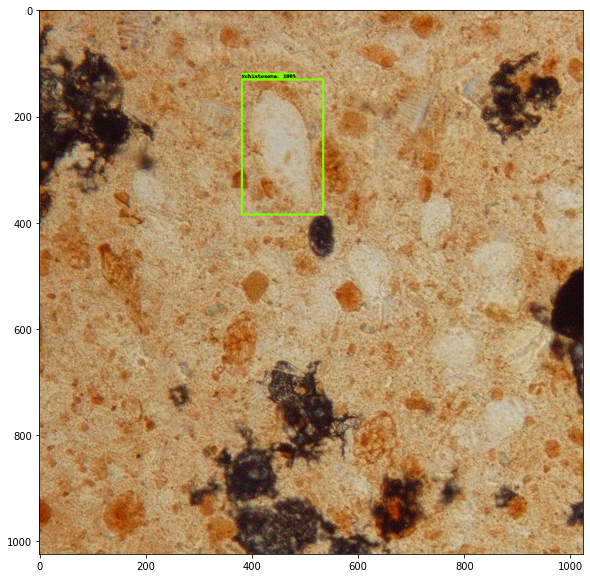


|-------|-------|-------|-------|-------|-------|-------|
Rodando inferencia para images/test/Schistosoma 3.JPG... Done

CLASSE - PROBABILIDADE - CAIXA [ymin xmin ymax xmax]
Schistosoma - 1.0 - [179 311 473 523]
Schistosoma - 0.70134985 - [239 357 461 521]



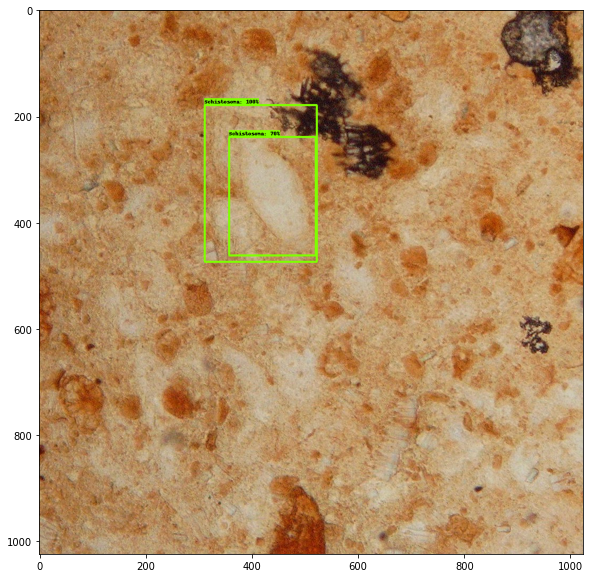


|-------|-------|-------|-------|-------|-------|-------|
Rodando inferencia para images/test/Schistosoma 23.JPG... Done

CLASSE - PROBABILIDADE - CAIXA [ymin xmin ymax xmax]
Schistosoma - 0.66955125 - [622 592 756 821]



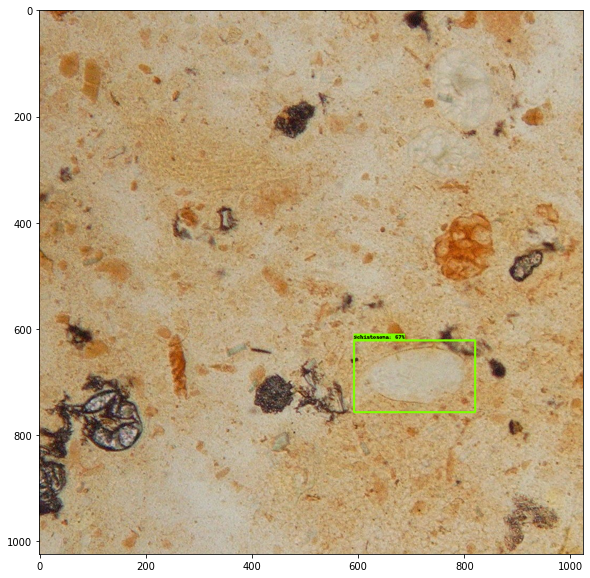


|-------|-------|-------|-------|-------|-------|-------|
Rodando inferencia para images/test/Schistosoma 23.JPG... Done

CLASSE - PROBABILIDADE - CAIXA [ymin xmin ymax xmax]
Schistosoma - 0.66955125 - [622 592 756 821]



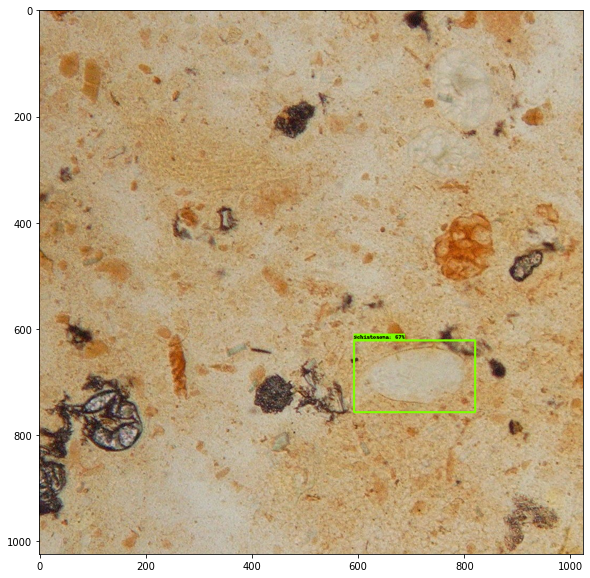


|-------|-------|-------|-------|-------|-------|-------|
Rodando inferencia para images/test/Schistosoma 7_1.JPG... Done

CLASSE - PROBABILIDADE - CAIXA [ymin xmin ymax xmax]



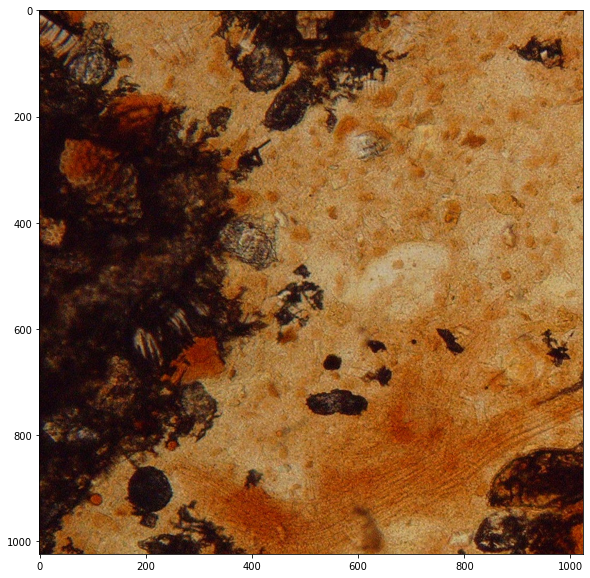


|-------|-------|-------|-------|-------|-------|-------|
Rodando inferencia para images/test/Schistosoma 9_1.JPG... Done

CLASSE - PROBABILIDADE - CAIXA [ymin xmin ymax xmax]
Schistosoma - 0.9984895 - [125 483 352 684]



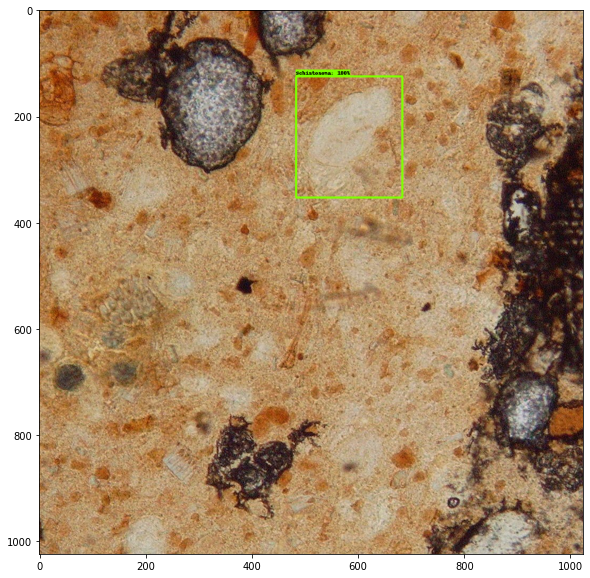


|-------|-------|-------|-------|-------|-------|-------|
Rodando inferencia para images/test/Schistosoma 3.JPG... Done

CLASSE - PROBABILIDADE - CAIXA [ymin xmin ymax xmax]
Schistosoma - 1.0 - [179 311 473 523]
Schistosoma - 0.70134985 - [239 357 461 521]



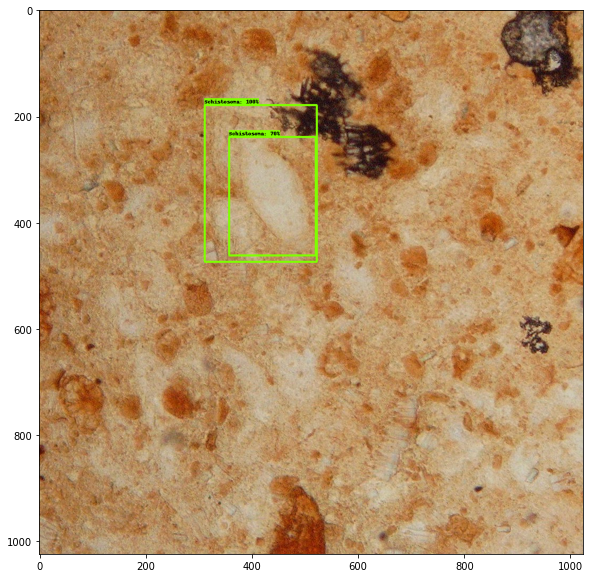


|-------|-------|-------|-------|-------|-------|-------|
Rodando inferencia para images/test/Schistosoma 9_1.JPG... Done

CLASSE - PROBABILIDADE - CAIXA [ymin xmin ymax xmax]
Schistosoma - 0.9984895 - [125 483 352 684]



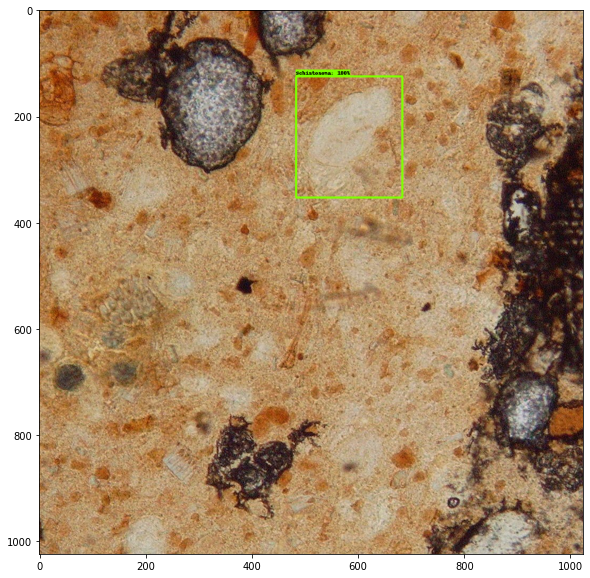


|-------|-------|-------|-------|-------|-------|-------|
Rodando inferencia para images/test/Schistosoma 18.JPG... Done

CLASSE - PROBABILIDADE - CAIXA [ymin xmin ymax xmax]
Schistosoma - 0.99999917 - [353 416 546 596]



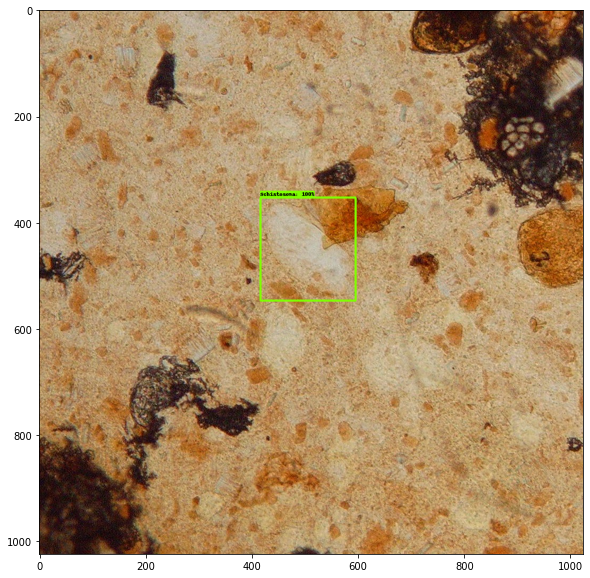


|-------|-------|-------|-------|-------|-------|-------|
Rodando inferencia para images/test/Schistosoma 18.JPG... Done

CLASSE - PROBABILIDADE - CAIXA [ymin xmin ymax xmax]
Schistosoma - 0.99999917 - [353 416 546 596]



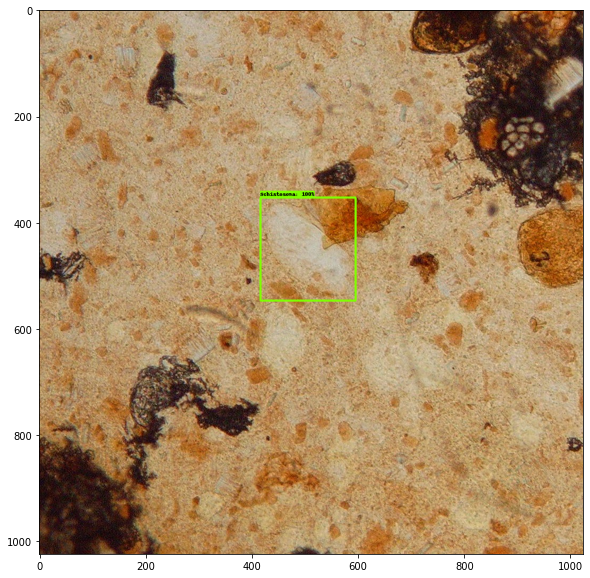

In [22]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

#IMAGE_PATHS = glob.glob("/home/smart/Desktop/sva-vwm-ms/dataset/initial/*.jpg")
#IMAGE_PATHS = glob.glob("/home/smart/Desktop/sva-vwm-ms/dataset/initial/bayOriginal (13).jpg")
IMAGE_PATHS = glob.glob("images/test/*.JPG")
#IMAGE_PATHS = glob.glob("/home/smart/Desktop/sva-vwm-ms/dataset/extracted-200729-200807/cam01/*.jpg")
#reduce amount of images randomly
IMAGE_PATHS_small = np.random.choice(IMAGE_PATHS, 10)

for image_path in IMAGE_PATHS_small:

    print("\n|-------|-------|-------|-------|-------|-------|-------|")
    print('Rodando inferencia para {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    #mexi no detection para pegar somente classes que eu quero
    detection_classes = []
    detection_scores = []
    detection_boxes = []
    
    limiar_deteccao = 0.1
    for i in range(len(detections['detection_scores'])):
        if detections['detection_scores'][i] >= limiar_deteccao and detections['detection_classes'][i] in category_index:
            detection_classes.append(detections['detection_classes'][i])
            detection_scores.append(detections['detection_scores'][i])
            detection_boxes.append(detections['detection_boxes'][i])
    
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        np.asarray(detection_boxes),
        np.asarray(detection_classes),
        np.asarray(detection_scores),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=limiar_deteccao,
        agnostic_mode=False)

    plt.figure(figsize=(10,10))
    plt.imshow(image_np_with_detections)
    print('Done')

    #convert coordinates normalized in pixels
    #ymin,xmin,ymax,xmax
    detection_boxes_pixels = np.squeeze(detection_boxes)
    #adjust for when there is only one detection
    if str(detection_boxes_pixels.shape) == '(4,)':
        detection_boxes_pixels = np.reshape(detection_boxes_pixels, (1, len(detection_boxes_pixels)))
    for i in range(len(detection_boxes)):
        detection_boxes_pixels[i,0] = (int(detection_boxes_pixels[i,0]*image_np.shape[0]))
        detection_boxes_pixels[i,1] = (int(detection_boxes_pixels[i,1]*image_np.shape[1]))
        detection_boxes_pixels[i,2] = (int(detection_boxes_pixels[i,2]*image_np.shape[0]))
        detection_boxes_pixels[i,3] = (int(detection_boxes_pixels[i,3]*image_np.shape[1]))
        #print(detection_boxes_pixels[i,0], detection_boxes_pixels[i,1], detection_boxes_pixels[i,2], detection_boxes_pixels[i,3])


    print("\nCLASSE - PROBABILIDADE - CAIXA [ymin xmin ymax xmax]")
    for i in range(len(np.asarray(detection_classes))):
        print(category_index[int(np.asarray(detection_classes[i]))]['name'],"-",
        np.asarray(detection_scores[i]),"-", detection_boxes_pixels[i].astype(int))
    print()      
    plt.show()

# sphinx_gallery_thumbnail_number = 2